##### We train model to recognise single fruit, 
##### model is abridged version of VGG16, https://datagen.tech/guides/computer-vision/vgg16/
#####
##### After model is trained , we check accuracy
#####
##### Then we apply R CNN approach: picture of choice is broken into multiple sub pics(proposals)
#####  and we employ previously trained model to check if sub pic contains apple
#####
##### Current implementation does not require manual labelling

https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e

https://www.analyticsvidhya.com/blog/2022/02/blood-cell-detection-in-image-using-naive-approach/

In [1]:
# upload libraries to prepare data
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt


In [398]:
## We preprocess data which constitutes both trainig and test pics,  later we would apply
## train_test_split method to generate 80 20 split, 
## script below preprocess 0 and 1 classes( non apple , apple )
## We label 1 for units which represent Red Apples

In [2]:
# verify location

IMG_HEIGHT = 250
IMG_WIDTH = 250

folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test"
folder_train

'D:\\0_Desctop_Files\\Learning\\UTM_Project\\1_Prototype\\1_Raw_Data_Train_Test'

In [3]:
os.listdir(folder_train)

['apple_y_braeburn_1',
 'apple_y_crimson_snow_1',
 'apple_y_red_1',
 'apple_y_red_2',
 'apple_y_red_3',
 'apple_y_red_delicios_1',
 'apple_y_red_yellow_1',
 'cabbage_white_1',
 'cucumber_1',
 'cucumber_3',
 'forest_train_test',
 'zucchini_1',
 'zucchini_dark_1']

In [4]:
## import pictures and generate labels to train model

img_data_array_0_class=[] # store pixels  of 0 class
img_data_array_1_class=[] # store pixels of apples pictures


for dir1 in os.listdir(folder_train): # loop through files in each folder
    for dir2 in os.listdir ( os.path.join(folder_train, dir1) ):
    
         if dir1 !="forest_train_test":
            image_path= os.path.join(folder_train, dir1,  dir2) # full path to file we need to upload

            image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimentions

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB

              ## 1 class is stored separately as lated we need to augment pictures plus we add white padding
            if dir1.split("_")[1]=="y": # if file with pictures contains "y" in name , then its 1, red apple, 0 otherwise
                image = cv2.copyMakeBorder(image, 30, 30, 30, 30, cv2.BORDER_CONSTANT, None, value=[255, 255, 255] )

                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                             interpolation = cv2.INTER_AREA)

                img_data_array_1_class.append(image) # append each picture to single structure
                   # function adds 20 pixelf of white padding to picture with apple
            else:
                image = cv2.copyMakeBorder(image, 30, 30, 30, 30, cv2.BORDER_CONSTANT, None, value=[255, 255, 255] )
                
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                             interpolation = cv2.INTER_AREA)

                img_data_array_0_class.append(image) # append each picture to single structure
            
            
       

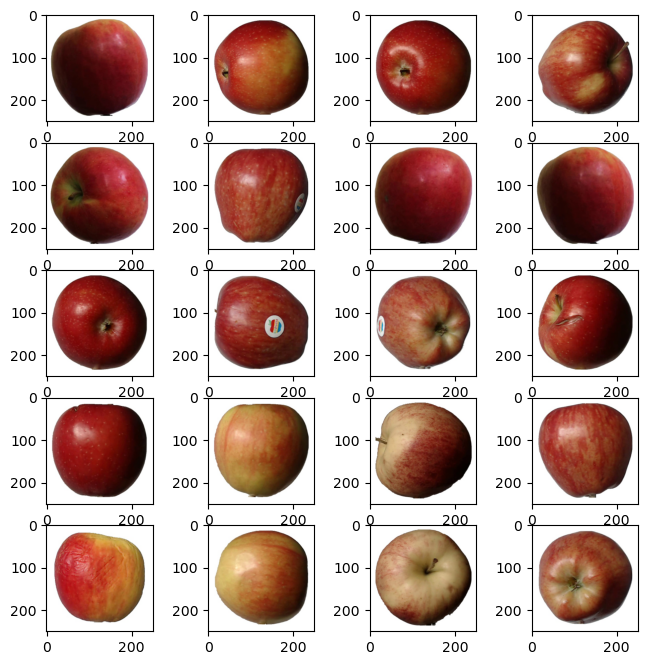

In [5]:
# debug
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_1_class),1 )
    img= img_data_array_1_class[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

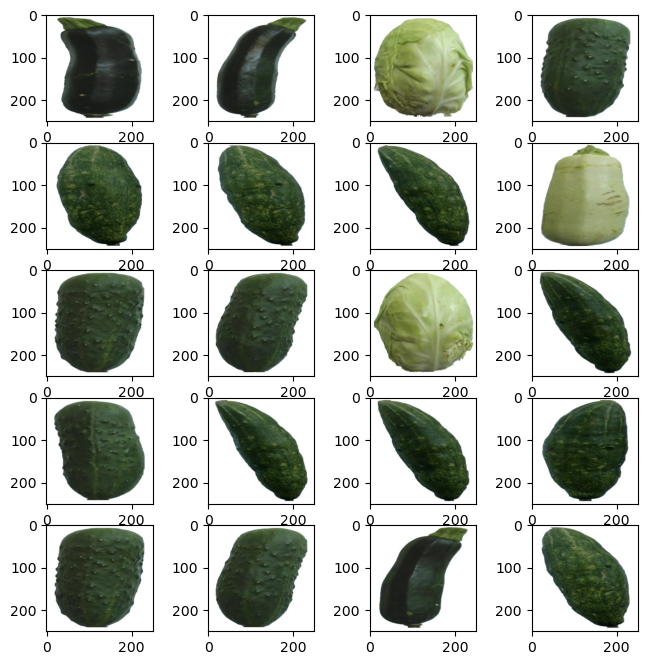

In [6]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_0_class),1 )
    img= img_data_array_0_class[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [91]:
########## Generate picture blending for backgroud
### we would avoid training models of pictures with white backgroups
### being unrealistic in real circumstances

In [7]:
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\1_Raw_Data_Train_Test\forest_train_test"

img_data_array_backgroud=[] # store pixels 

for dir1 in os.listdir(folder_train): # loop through files in each folder
    
        image_path= os.path.join(folder_train, dir1)
        
        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
        
        
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                         interpolation = cv2.INTER_AREA)
       
        img_data_array_backgroud.append(image) # append each picture to single structure
       

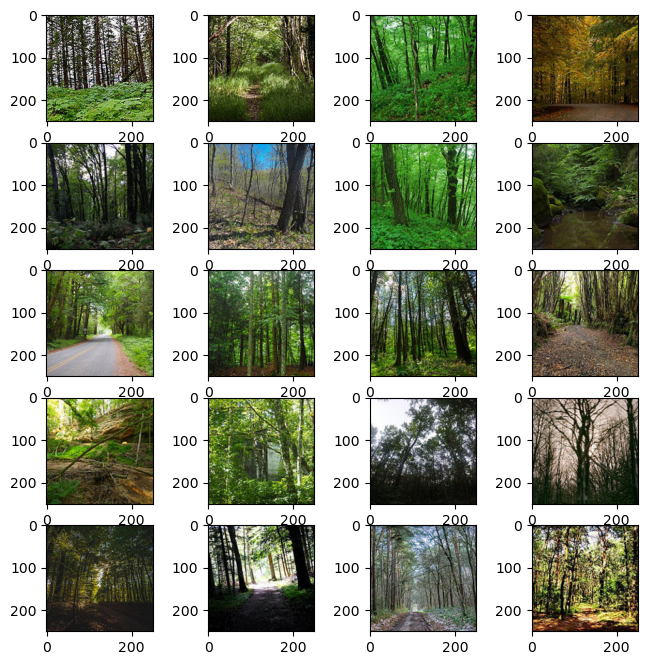

In [8]:
# debug
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_backgroud),1 )
    img= img_data_array_backgroud[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

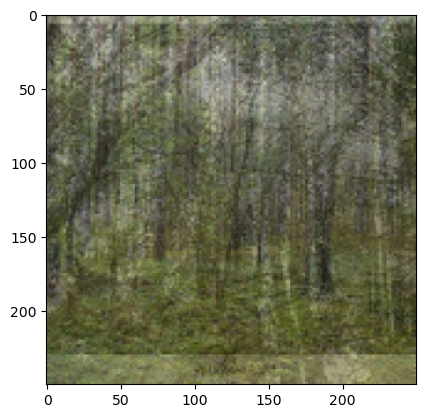

In [9]:
#### Sample of blended backgroupd
loc = np.random.randint(1, len(img_data_array_backgroud) ,5 )
equal_fraction = 1 / 5
output = np.zeros_like( img_data_array_backgroud[0] )
list_images = [ img_data_array_backgroud[loc[0]] , 
                img_data_array_backgroud[loc[1]] ,
                img_data_array_backgroud[loc[2]]  ,
                img_data_array_backgroud[loc[3]] ,
                img_data_array_backgroud[loc[4]] ]

for img in list_images:
    output = output + img * equal_fraction
    
output = output.astype(np.uint8)    

plt.imshow(output)

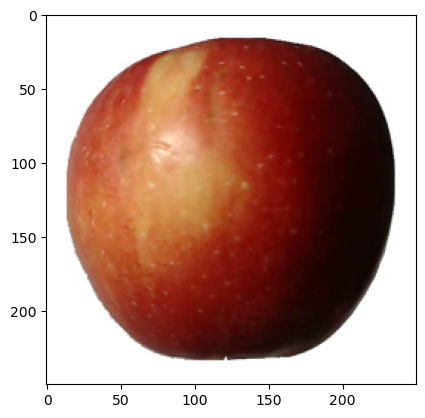

In [10]:
apple = img_data_array_1_class[0] 
plt.imshow( img_data_array_1_class[0] ) # debug

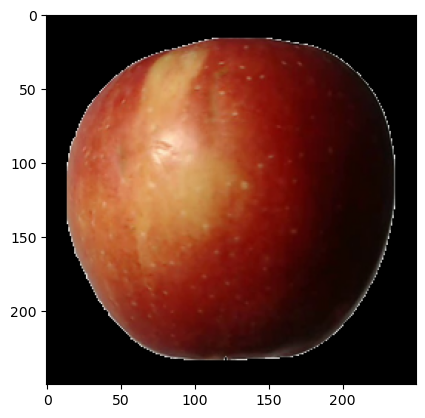

In [11]:
white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)

masked_image = np.copy(apple)
masked_image[white_filter != 0] = [0, 0, 0]
plt.imshow(masked_image)

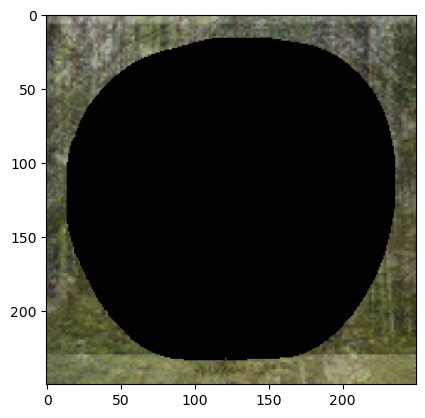

In [12]:
background_image = output.copy()
background_image[~(white_filter)] = [0,0,0]
plt.imshow(background_image)

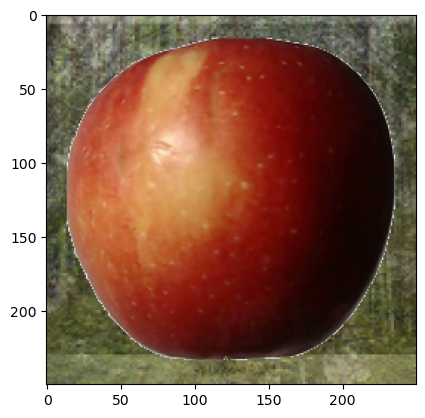

In [13]:
complete_image = masked_image + background_image
plt.imshow(complete_image)

In [14]:
####### Now  process all labels via loop
path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"

for i in range( 0  ,  len(img_data_array_1_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,4 )
           # print( loc )  locations are random
            equal_fraction = 1 / 4
            background = np.zeros_like( img_data_array_backgroud[0] )
            list_images = [ img_data_array_backgroud[loc[0]] , 
                            img_data_array_backgroud[loc[1]] ,
                            img_data_array_backgroud[loc[2]]  ,
                            img_data_array_backgroud[loc[3]] ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            apple = img_data_array_1_class[i] 
            
            white_filter = (apple[:,:,0] > 230) & (apple[:,:,1] > 230) & (apple[:,:,2] > 230)
            
            masked_image = apple.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            
     ## form final image
    
            complete_image = masked_image + background
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )    
            cv2.imwrite(path_export_full, complete_image )
            
            apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, apple )
            
            
y_count = len( img_data_array_1_class )  * 2          

In [15]:
[y_count , complete_image.shape]

[6460, (250, 250, 3)]

In [16]:
################ Now generate Train Augmented for 0 class, by slicing the picture into 9 parts and selection random one
height = int( IMG_HEIGHT / 3 ) # ( 3 * 3 = 9 pics )
width = int( IMG_WIDTH / 3 )
height,width # debug

(83, 83)

In [17]:
#### We would create coordinates for each piece out of 9 and would sample 
#### 1 sub pic from each downloaded picture of apple
x_start = np.arange( start = 0 , stop = IMG_HEIGHT -  width , step = width)
y_start = x_start.copy()

In [18]:
#### Reupload data and sample 1 sub image from each photo of target class
folder_train = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\2_Train_Test_Augmented_1_class"
# os.listdir( folder_train )

In [19]:
img_data_array_gen_pics=[] # store pixels 

for dir1 in os.listdir ( folder_train ):
         
        image_path= os.path.join(folder_train, dir1)

        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
        
        image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                         interpolation = cv2.INTER_AREA)
           
        ## set coordinates for sub pic (proposal)    
        random_coordinates = np.random.randint(low=0 , high=3, size = 2)
        loc_x = random_coordinates[0]
        loc_y = random_coordinates[1]

        timage =  image[ x_start[loc_x]:(x_start[loc_x]+width) , y_start[loc_y]:(y_start[loc_y]+height) ]
        
        timage = cv2.resize(timage, (IMG_HEIGHT, IMG_WIDTH), # make all pictures standard
                                 interpolation = cv2.INTER_AREA)
        # plt.imshow(buf_del )
        
       
        img_data_array_gen_pics.append(timage) # append each picture to single structure
 

In [20]:
len(img_data_array_gen_pics) == y_count     

True

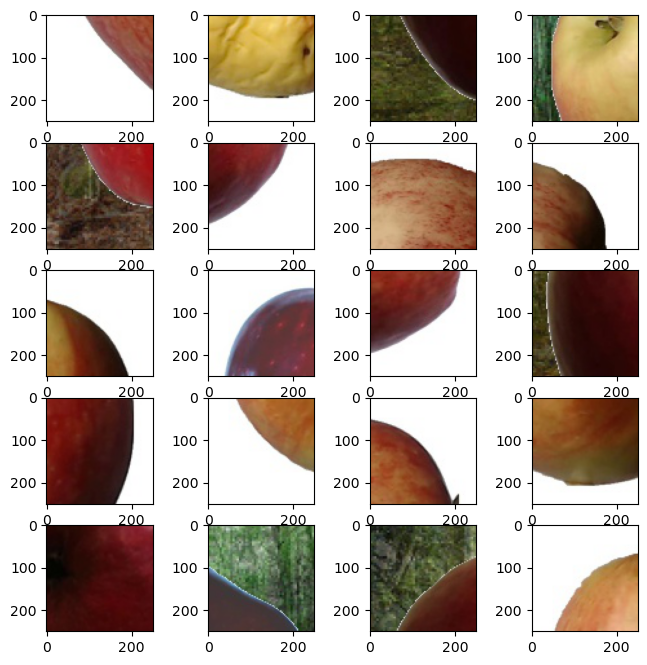

In [21]:
# debug
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    loc = np.random.randint(1, len(img_data_array_gen_pics),1 )
    img= img_data_array_gen_pics[loc[0]]  # debug
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [369]:
########## Export photos to Train Augmented , 0 class

In [22]:
path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\3_Train_Test_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_gen_pics) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_gen_pics[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )

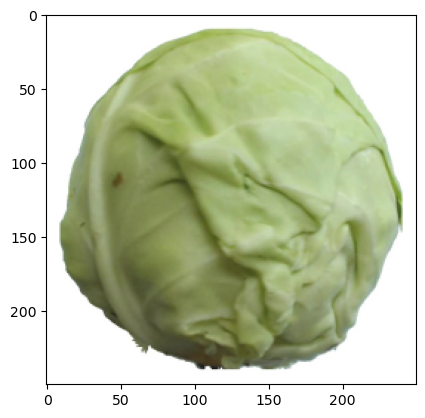

In [23]:
plt.imshow ( img_data_array_0_class[0] )

In [24]:
for i in range( 0  ,  len(img_data_array_0_class) ) :  # len(img_data_array_1_class)

    ## generate backgroud
            loc = np.random.randint(1, len(img_data_array_backgroud) ,4 )
           # print( loc )  locations are random
            equal_fraction = 1 / 4
            background = np.zeros_like( img_data_array_backgroud[0] )
            list_images = [ img_data_array_backgroud[loc[0]] , 
                            img_data_array_backgroud[loc[1]] ,
                            img_data_array_backgroud[loc[2]]  ,
                            img_data_array_backgroud[loc[3]] ]

            for img in list_images:
                background = background + img * equal_fraction

            background = background.astype(np.uint8) ## cv2 visualise matrices of integers   
      
     ## sequentially process pictures with target
            other = img_data_array_0_class[i] 
            
            white_filter = (other[:,:,0] > 230) & (other[:,:,1] > 230) & (other[:,:,2] > 230)
            
            masked_image = other.copy()          
            masked_image[white_filter != 0] = [0, 0, 0]
            
            background[~(white_filter)] = [0,0,0]
            
     ## form final image
    
            complete_image = masked_image + background
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_other"+str(i)+".jpg" )           
            cv2.imwrite(path_export_full, complete_image )
            
            other = cv2.cvtColor(other, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            path_export_full = os.path.join ( path_export , "picture_orig"+str(i)+".jpg" )          
            cv2.imwrite(path_export_full, other )
            
              

In [397]:
##### Therefore

### Train 1 labels are uploaded from Train_Augmented_1_class

### Train 0 labels are uploaded from Train_Augmented_0_class
### img_data_array_0_class contains photos pf other vegetables and forest

In [25]:
img_data_array_0_class[0].size

187500

In [26]:
######### Export Non Augmented 0 class stored in img_data_array_0_class

path_export = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\4_Train_Test_NON_Augmented_0_class"

for i in range( 0  ,  len(img_data_array_backgroud) ) :  # len(img_data_array_1_class)

            complete_image = img_data_array_backgroud[i]
        
            complete_image = cv2.cvtColor(complete_image, cv2.COLOR_BGR2RGB) # make sure that scheme is RGB
            
            path_export_full = os.path.join ( path_export , "picture_nature"+str(i)+".jpg" )
            
            cv2.imwrite(path_export_full, complete_image )

In [27]:
###### Check 1 cs 0 labels
[ y_count / (len(img_data_array_0_class) + len(img_data_array_gen_pics)) , y_count + (len(img_data_array_0_class) + len(img_data_array_gen_pics)) ]


[0.8639828808345593, 13937]